# Beta Bank Case: Will The Existing Client Withdraw the Contracts for Bank Services?

## Project Description

The clients of "Beta Bank" (name of the bank is changed for confidential purposes) started to stop using the bank services. The bank top management worries about that. Beta Bank's marketing specialists believe that to save current clients is cheaper in terms of costs then to attrace new ones.

### TASK 
The task for the project is to predict whether existing Beta Bank's clients are going to stop using the bank services in upcoming future. 

### DATA
There is an archived data given, including the data about contracts withdrawal by the current clients.

### METHODOLOGY
- **To build a machine learning model with a maximun F1-score (at least F1-score = 0.59). The model is to be tested on the test data.**
- **To measure AUC-ROC score and compare it with F1-score.**

## Variables Description

**Features**

- RowNumber - index in the data rows

- CustomerId

- Surname

- CreditScore — cridit history, client's credit raiting

- Geography — страна проживания

- Gender

- Age

- Tenure — number of years for how long the client was staying with the bank

- Balance — current account's balance

- NumOfProducts

- HasCrCard — binary valriables: Does a client have a credit card?

- IsActiveMember - binary valriables: Is a client actively using the bank for transactions?

- EstimatedSalary



**Target**

•	_**Exited**_ — the fact the the client has withdrawn the contract

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None 

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score, make_scorer, classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

## 1 - Data Pre-processing

In [2]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [5]:
from pandas_profiling import ProfileReport

In [6]:
data = pd.read_csv('/Users/yuliabezginova/Documents/DS/praktikum/project-6_ML_banking/Churn.csv')

print(data.shape)
print(data.head(5))

(10000, 14)
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Having a brief look on the data quality via histograms:

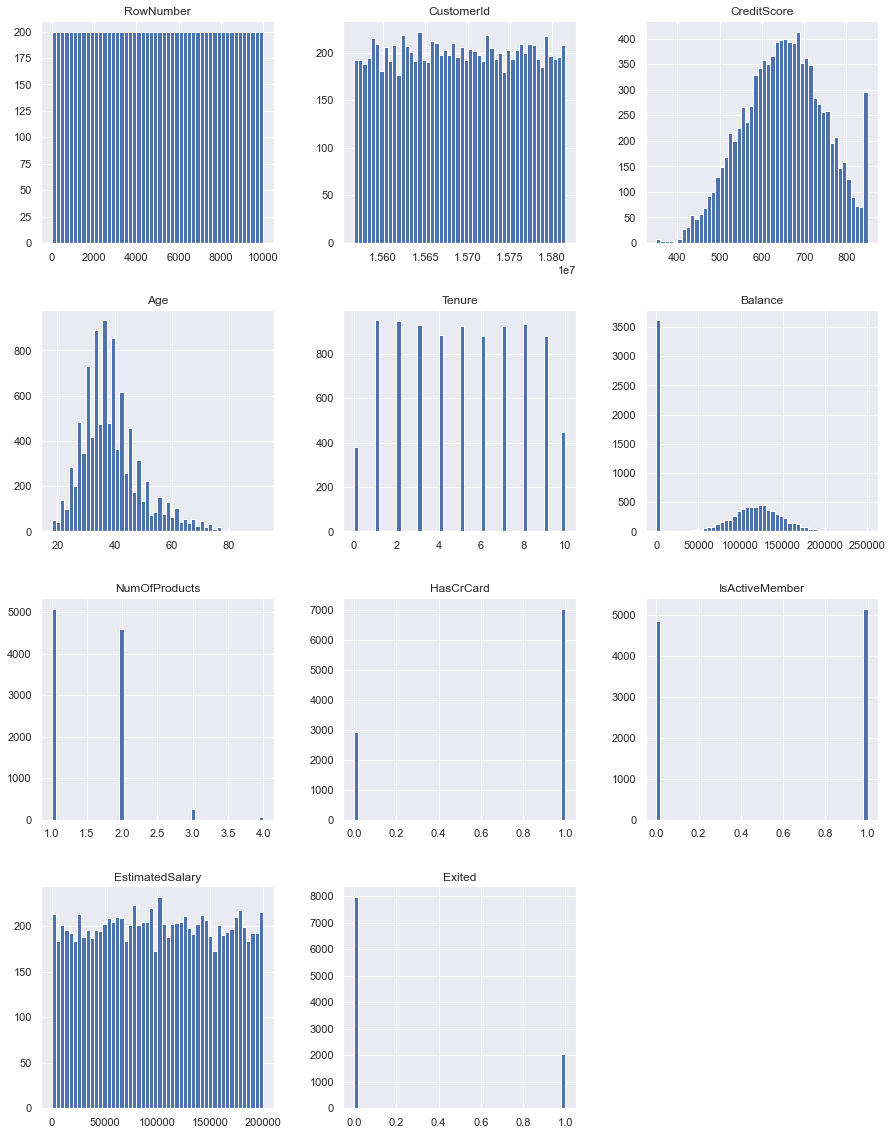

In [8]:
data.hist(bins=50, figsize=(15, 20));
None

Checking the datasets for missing values:

**Explorative Data Analysis (EDA) with Pandas Profiling.**

In [13]:
report = ProfileReport(data)

In [11]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Column _Tenure_ contains missings.

In [15]:
data['Tenure'] = data['Tenure'].fillna(data.groupby('Balance')['Tenure'].transform('median'))
data['Tenure'].isna().sum() / len(data)

0.0575

**As long as the share of missings is 5.75%, we can safely remove them from the dataset. Another option to deal with missings is to fill them with random values since there are no clear reasons why those missings occur.**

In [16]:
data = data.dropna(subset=['Tenure'])

In [17]:
data['Tenure'].isna().sum()

0

Missings from the column _Tenure_ is removed. **Final check for missing values:**

In [18]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

Data is ready for further analysis.

## 2 - Checking target classes disbalance. Training the model without taking into account target classes disbalance.


### 2.1 Coding variables using OHE process

**For machine learning model training we will need the following columns - CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary.** Among of them, there is a _Gender_, _Geography_ we have to code with dummy variables using **One-Hot Encoding, OHE**.

**FYI**

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

Check out [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?ref=hackernoon.com) for more details about OHE.

Removing three unecessary columns for modelling:

In [19]:
data = data.drop(columns=['Surname', 'RowNumber', 'CustomerId'])

Applying OHE and saving a new dataset for further analysis:

In [20]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [21]:
data_ohe.head(10)

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42     2.0       0.00              1          1   
1          608   41     1.0   83807.86              1          0   
2          502   42     8.0  159660.80              3          1   
3          699   39     1.0       0.00              2          0   
4          850   43     2.0  125510.82              1          1   
5          645   44     8.0  113755.78              2          1   
6          822   50     7.0       0.00              2          1   
7          376   29     4.0  115046.74              4          1   
8          501   44     4.0  142051.07              2          0   
9          684   27     2.0  134603.88              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0               1        101348.88       1                  0   
1               1        112542.58       0                  0   
2               0        113931.57       1                  0   
3               0         93826.63       0                  0   
4               1         79084.10       0                  0   
5               0        149756.71       1                  0   
6               1         10062.80       0                  0   
7               0        119346.88       1                  1   
8               1         74940.50       0                  0   
9               1         71725.73       0                  0   

   Geography_Spain  Gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4                1            0  
5                1            1  
6                0            1  
7                0            0  
8                0            1  
9                0            1

### 2.2 Spliting the data into three subsamples for three different purposes: training, validation and testing.

```
As a benchmark, we split the sample in the proportion as follows:
- 60% train_data
- 20% validation_data
- 20% test_data

```

In [22]:
train_data, other_data = train_test_split(data_ohe, test_size=0.30, random_state=2355555)
validation_data, test_data = train_test_split(other_data, test_size=0.70, random_state=2355555)

print('Train sample size:', train_data.shape[0])
print('Validation sample size:', validation_data.shape[0])
print('Test sample size:', test_data.shape[0])

Train sample size: 6597
Validation sample size: 848
Test sample size: 1980


**Determine features and targets for the model.**

In [23]:
train_data_features = train_data.drop(['Exited'], axis=1)
train_data_target = train_data['Exited']

In [24]:
validation_data_features = validation_data.drop(['Exited'], axis=1)
validation_data_target = validation_data['Exited']

In [25]:
test_data_features = test_data.drop(['Exited'], axis=1)
test_data_target = test_data['Exited']

**Dataset was split into three subsamples 60/20/20.**

- The model will be trained using _train_data_
- The model will be validated using _validation_data_
- The best model will be run using _test_data_

### 2.3 Modelling

#### 2.3.1 Decision Tree

In [27]:
%%time

best_depth_tree = 0
best_f1_dt = 0
best_model_tree = None
best_crit_tree = None

for crit in {'gini', 'entropy'}:
    for depth in range(1, 101):
        model = DecisionTreeClassifier(max_depth=depth, random_state=2355555, criterion=crit)
        model.fit(train_data_features, train_data_target)
        valid_predictions = model.predict(validation_data_features)
        # посчитаем F1-меру модели на валидационной выборке
        f1_dt = f1_score(validation_data_target, valid_predictions)
        if f1_dt > best_f1_dt:
            best_depth_tree = depth
            best_f1_dt = f1_dt
            best_model_tree = model
            best_crit_tree = crit
        
print('The best tree depth:', best_depth_tree,
      '\nThe best F1-score:', best_f1_dt,
      '\nThe best value of criterion:', best_crit_tree)

The best tree depth: 7 
The best F1-score: 0.5454545454545454 
The best value of criterion: gini
CPU times: user 7.25 s, sys: 104 ms, total: 7.35 s
Wall time: 7.73 s


**The best hyper parameters for the _Decision Tree_:**

- The best tree depth: 7 
- The best F1-score: 0.5454545454545454 
- The best value of criterion: gini
- _Run time: 7.73 sec._

#### 2.3.2 Random Forest

In [29]:
%%time 

best_crit_random_forest = None
best_model_random_forest = None
best_f1_random_forest = 0
best_estimator_random_forest = 0
best_boot_random_forest = False
best_warm_random_forest = False

for est in range(1, 51):
    for crit in {'gini', 'entropy'}:
        for boot in {False, True}:
            for warm in {False, True}:
                model = RandomForestClassifier(random_state=2355555, warm_start=warm, bootstrap=boot, criterion=crit, n_estimators=est)
                # обучим модель с заданным значением энтропии
                model.fit(train_data_features, train_data_target)
                # обучим модель на тренировочной выборке
                valid_predictions = model.predict(validation_data_features)
                # посчитаем F1-меру модели на валидационной выборке
                f1_rf = f1_score(validation_data_target, valid_predictions)
                if f1_rf > best_f1_random_forest:
                    best_crit_random_forest = crit
                    best_model_random_forest = model
                    best_f1_random_forest = f1_rf
                    best_estimator_random_forest = est
                    best_boot_random_forest = boot
                    best_warm_random_forest = warm

print('The best number of iterations:', best_estimator_random_forest, 
      '\nThe best F1-score:', best_f1_random_forest,
      '\nThe best value of criterion:', best_crit_random_forest,
     '\nThe best value of warm_start:', best_warm_random_forest,
      '\nThe best value of bootstrap:', best_boot_random_forest)

The best number of iterations: 25 
The best F1-score: 0.5577689243027888 
The best value of criterion: gini 
The best value of warm_start: False 
The best value of bootstrap: True
CPU times: user 1min 55s, sys: 3.26 s, total: 1min 58s
Wall time: 2min 2s


**The best hyper parameters for _random forest_ model:**

- Best F1-score: **0.5578**
- The best number of trees: _**n_estimators=25**_
- The best value of enthropy (criterion) _**'gini'**_
- The best valus of _warm_start_: _**False**_
- The best value of _bootstrap_: _**True**_
- _Run time_ - **2 min 2 s**

#### 2.3.3 Logistic Regression

In [30]:
%%time

best_max_iter = 0
best_f1_log = 0
best_solver = ''
best_model_logreg = None
# best_C = 0.0

for solve in {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}:
    # for float_c in [x/10 for x in range(1, 5)]:
    for max_iter in range(1, 11):
        model = LogisticRegression(random_state=2355555, solver=solve)
        model.fit(train_data_features, train_data_target)
        valid_predictions = model.predict(validation_data_features)
        f1_log_reg = f1_score(validation_data_target, valid_predictions)
        if f1_log_reg > best_f1_log:
            best_solver= solve
            best_max_iter = max_iter
            best_f1_log = f1_log_reg
            best_model_logreg = model
            # best_C = float_c

print('The best number of iterations:', best_max_iter, 
      '\nThe best F1-score:', best_f1_log,
      '\nThe best value of solver:', best_solver)

      # '\nЛучшее значение гиперпараметра С:', best_C)    

The best number of iterations: 1 
The best F1-score: 0.3076923076923077 
The best value of solver: newton-cg
CPU times: user 15.8 s, sys: 470 ms, total: 16.2 s
Wall time: 11.7 s


**The best hyper parameters in _logistic regression_ model:**
- The best number of iterations: **1**
- The best F1-score: **0.3062** 
- The best number of _solver_: **newton-cg**
- _Run time:_ 11.7 sec

Now it is time to check the model for adequacy. We are going to do it in two ways: 

1) building a constant model with measuring recall, precision and F1-score;

2) building AUC-ROC curve and calculating the value.

### 2.4 Checking the models for adequacy

#### 2.4.1 Constant model with three metrics - recall, precision, F1-score

0    0.798196
1    0.201804
Name: Exited, dtype: float64


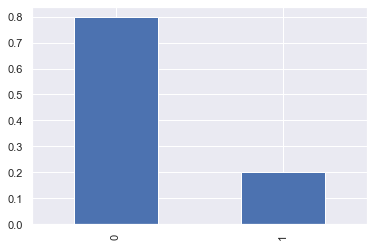

In [31]:
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)

class_frequency.plot(kind='bar');

In [32]:
target_pred_constant = pd.Series(0, index=train_data_target.index)
accuracy_score(train_data_target, target_pred_constant)

0.7941488555403972

**FYI: В качестве проверки на адекватность используем precision, recall и F1-меру.**

```
Полнота и точность оценивают качество прогноза положительного класса с разных позиций. 

- Recall описывает, как хорошо модель разобралась в особенностях этого класса и распознала его. 

- Precision выявляет, не переусердствует ли модель, присваивая положительные метки.

- Контролировать их параллельно помогают агрегирующие метрики, одна из которых — F1-мера (англ. F1-score). Это среднее гармоническое полноты и точности. Единица в F1 означает, что соотношение полноты и точности равно 1:1.
```

In [34]:
model = DecisionTreeClassifier(random_state=2355555)
model.fit(train_data_features, train_data_target)
predicted_valid = model.predict(validation_data_features)

precision = precision_score(validation_data_target, predicted_valid, pos_label=1)
recall = recall_score(validation_data_target, predicted_valid, pos_label=1)
f1 = f1_score(validation_data_target, predicted_valid)

print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Recall: 0.42207792207792205
Precision: 0.41935483870967744
F1-score: 0.4207119741100323


DummyClassifier helps to understand how non-informative those above metrics can be.

In [36]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(train_data_features, train_data_target)
pred_most_frequent = dummy_majority.predict(validation_data_features)
print("Unique forecasted metrics: {}".format(np.unique(pred_most_frequent)))
print("Accuracy on the test_data: {:.2f}".format(dummy_majority.score(validation_data_features, validation_data_target)))

Unique forecasted metrics: [0]
Accuracy on the test_data: 0.82


**From the output above we can conclude that there is a model accuracy (without any training) is 82% for a majority class, which is not informative at all.**

This means we have to check the model for adequacy with a more reliable metrics.

#### 2.4.2 AUC-ROC Decision Tree (train)

In [37]:
from sklearn.metrics import roc_curve

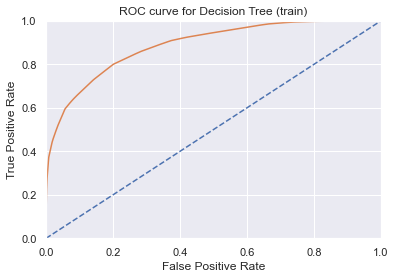

In [45]:
probabilities_train = best_model_tree.predict_proba(train_data_features)
probabilities_one_train = probabilities_train[:, 1]

fpr, tpr, thresholds = roc_curve(train_data_target, probabilities_one_train)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC curve for Decision Tree (train)')
plt.show()

Calculate the square under the ROC curve using the functions _roc_auc_score_:

In [41]:
auc_roc = roc_auc_score(train_data_target, probabilities_one_train)
f'Random Forest // model 1 AUC score: {auc_roc}'

'Random Forest // model 1 AUC score: 0.8874380460807003'

#### 2.4.3 AUC-ROC Random Forest (train)

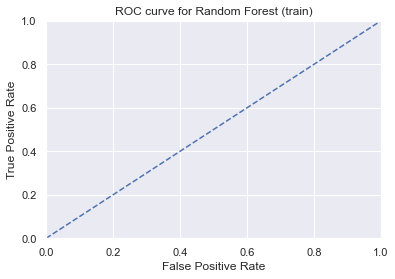

In [46]:
probabilities_train = best_model_random_forest.predict_proba(train_data_features)
probabilities_one_train = probabilities_train[:, 1]

fpr, tpr, thresholds = roc_curve(train_data_target, probabilities_one_train)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC curve for Random Forest (train)')
plt.show()

In [ ]:
Calculate the square under the ROC curve using the functions _roc_auc_score_:

In [47]:
auc_roc = roc_auc_score(train_data_target, probabilities_one_train)
print(f'Random Forest // model 1 AUC score: {auc_roc}')

Random Forest // model 1 AUC score: 0.9999739267153761


#### 2.4.4 AUC-ROC Logistic Regression (train)

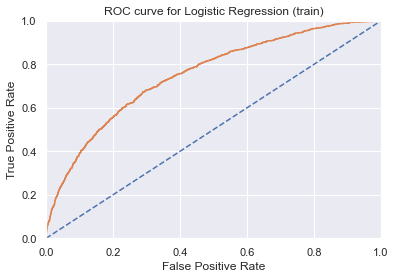

In [48]:
probabilities_train = best_model_logreg.predict_proba(train_data_features)
probabilities_one_train = probabilities_train[:, 1]

fpr, tpr, thresholds = roc_curve(train_data_target, probabilities_one_train)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC curve for Logistic Regression (train)')
plt.show()

In [49]:
auc_roc = roc_auc_score(train_data_target, probabilities_one_train)
print(f'Logistic Regression // model 1 AUC score: {auc_roc}')

Logistic Regression // model 1 AUC score: 0.7522016112868226


#### The AUC-score for Random Forest model is 0.99 (99%). Before wetrust this value, let's check AUC-score for validation data sample.

#### 2.4.5 Decision Tree (valid)

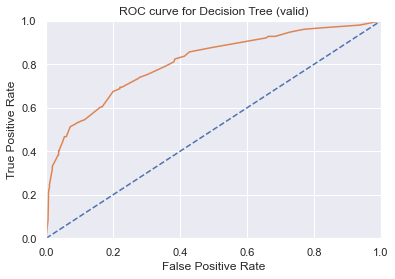

In [50]:
probabilities_valid = best_model_tree.predict_proba(validation_data_features)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(validation_data_target, probabilities_one_valid)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC curve for Decision Tree (valid)')
plt.show()

In [53]:
auc_roc = roc_auc_score(validation_data_target, probabilities_one_valid)
print(f'Decision Tree (valid_data) // AUC score: {auc_roc}')

Decision Tree (valid_data) // AUC score: 0.8086520827875295


#### 2.4.6 Random Forest (valid)

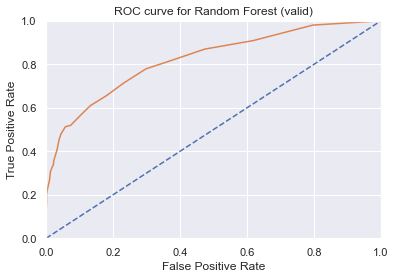

In [54]:
probabilities_valid = best_model_random_forest.predict_proba(validation_data_features)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(validation_data_target, probabilities_one_valid)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC curve for Random Forest (valid)')
plt.show()

In [55]:
auc_roc = roc_auc_score(validation_data_target, probabilities_one_valid)
print(f'Random Forest (valid_data) // AUC score: {auc_roc}')

Random Forest (valid_data) // AUC score: 0.8216952356001348


#### 2.4.7 Logistic Regression (valid)

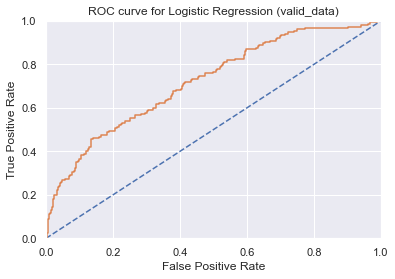

In [56]:
probabilities_valid = best_model_logreg.predict_proba(validation_data_features)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(validation_data_target, probabilities_one_valid)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC curve for Logistic Regression (valid_data)')
plt.show()

In [57]:
auc_roc = roc_auc_score(validation_data_target, probabilities_one_valid)
print(f'Logistic Regression (valid_data) // AUC score: {auc_roc}')

Logistic Regression (valid_data) // AUC score: 0.7200400464089225


#### AUC-ROC score for ***valid_data***:
- Decision Tree: 81%
- Random Forest: 82%
- Logistic Regression: 72%

## 3 - Improving the model quality by taking into account target classes disbalance, choosing the best trained model.


Checking the target column 'Exited' for class disbalance.

In [59]:
data.Exited.value_counts()

0    7523
1    1902
Name: Exited, dtype: int64

##### CONCLUSION: target classes 0, 1 are not balanced; majority class is '0', which means that the model will be better trained for majority class '0' than '1' even with high values of all metrics (AUC-ROC, precision, recall).

In order to balance target we are going to use downsampling and upsampling techniques.

### 3.1 Downsampling

The parameter ***fraction*** put manually until the targets are balanced.

In [61]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=2355555)] + [features_ones])

    target_downsampled = target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=2355555)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=2355555)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(train_data_features, train_data_target, 0.265)
print(target_downsampled.value_counts())

print(features_downsampled.shape)
print(target_downsampled.shape)

0    1388
1    1358
Name: Exited, dtype: int64
(2746, 11)
(2746,)


#### After downsampling, train the models and check F1-score again for the data with balanced targets.

In [62]:
best_model_tree.fit(features_downsampled, target_downsampled)
predicted_valid = best_model_tree.predict(validation_data_features)

print("Decision Tree Model, F1:", f1_score(validation_data_target, predicted_valid))

Decision Tree Model, F1: 0.5310173697270472


In [63]:
best_model_random_forest.fit(features_downsampled, target_downsampled)
predicted_valid = best_model_random_forest.predict(validation_data_features)

print("Random Forest Model, F1:", f1_score(validation_data_target, predicted_valid))

Random Forest Model, F1: 0.511737089201878


In [64]:
best_model_logreg.fit(features_downsampled, target_downsampled)
predicted_valid = best_model_logreg.predict(validation_data_features)

print("LogisticRegression, F1:", f1_score(validation_data_target, predicted_valid))

LogisticRegression, F1: 0.43137254901960786


#### CONCLUSION: after balancing targets using downsampling, the bes models so far are Decision Tree (DT) and Random Forest (RF).

### 3.2 Upsampling

The parameter ***fraction*** put manually until the targets are balanced.

In [65]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled = shuffle(features_upsampled, random_state=2355555)
    target_upsampled = shuffle(target_upsampled, random_state=2355555)
    return features_upsampled, target_upsampled


features_zeros = train_data_features[train_data_features == 0]
features_ones = train_data_features[train_data_features == 1]
target_zeros = train_data_target[train_data_target == 0]
target_ones = train_data_target[train_data_target == 1]

# repeat = 10
# features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
# target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

features_upsampled, target_upsampled = upsample(train_data_features, train_data_target, 4)
print(target_upsampled.value_counts())

print(features_upsampled.shape)
print(target_upsampled.shape)

1    5432
0    5239
Name: Exited, dtype: int64
(10671, 11)
(10671,)


#### After upsampling, train the models and check F1-score again for the data with balanced targets.

In [67]:
best_model_tree.fit(features_upsampled, target_upsampled)
predicted_valid = best_model_tree.predict(validation_data_features)

print("Decision Tree Model, F1:", f1_score(validation_data_target, predicted_valid))

Decision Tree Model, F1: 0.5205479452054795


In [68]:
best_model_random_forest.fit(features_upsampled, target_upsampled)
predicted_valid = best_model_random_forest.predict(validation_data_features)

print("Random Forest Model, F1:", f1_score(validation_data_target, predicted_valid))

Random Forest Model, F1: 0.5296167247386759


In [69]:
best_model_logreg.fit(features_upsampled, target_upsampled)
predicted_valid = best_model_logreg.predict(validation_data_features)

print("LogisticRegression, F1:", f1_score(validation_data_target, predicted_valid))

LogisticRegression, F1: 0.4219409282700422


#### CONCLUSION: after balancing targets using upsampling, the bes models is Random Forest (RF).

Let's calculate and check AUC-ROC score for downsampled and upsampled data.

### 3.3 AUC-ROC score for down- and upsampled data

#### 3.3.1 Decision Tree (downsampled)

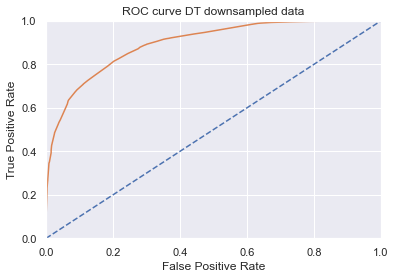

In [70]:
probabilities_down = best_model_tree.predict_proba(features_downsampled)
probabilities_one_downsampled = probabilities_down[:, 1]

fpr, tpr, thresholds = roc_curve(target_downsampled, probabilities_one_downsampled)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC curve DT downsampled data')
plt.show()

In [71]:
auc_roc = roc_auc_score(target_downsampled, probabilities_one_downsampled)
print(f'Decision Tree (downsampled) // AUC score: {auc_roc}')

Decision Tree (downsampled) // AUC score: 0.8955861943101612


#### 3.3.2 Random Forest (downsampled)

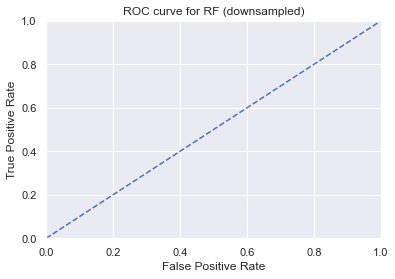

In [72]:
probabilities_down = best_model_random_forest.predict_proba(features_downsampled)
probabilities_one_downsampled = probabilities_down[:, 1]

fpr, tpr, thresholds = roc_curve(target_downsampled, probabilities_one_downsampled)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC curve for RF (downsampled)')
plt.show()

In [73]:
auc_roc = roc_auc_score(target_downsampled, probabilities_one_downsampled)
print(f'Random Forest // model 1 AUC score: {auc_roc}')

Random Forest // model 1 AUC score: 1.0


#### 3.3.3 Decision Tree (upsampled)

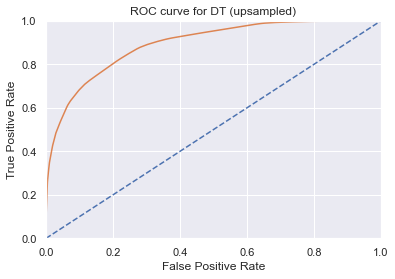

In [74]:
probabilities_up = best_model_tree.predict_proba(features_upsampled)
probabilities_one_upsampled = probabilities_up[:, 1]

fpr, tpr, thresholds = roc_curve(target_upsampled, probabilities_one_upsampled)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC curve for DT (upsampled)')
plt.show()

In [75]:
auc_roc = roc_auc_score(target_upsampled, probabilities_one_upsampled)
print(f'Decision Tree (upsampled) // AUC score: {auc_roc}')

Decision Tree (upsampled) // AUC score: 0.8929300918313735


#### 3.3.4 Random Forest (upsampled)

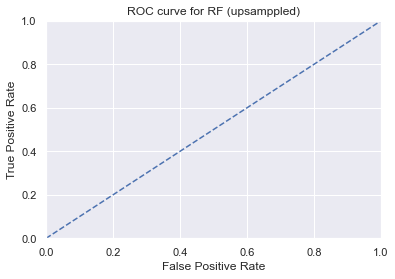

In [76]:
probabilities_up = best_model_random_forest.predict_proba(features_upsampled)
probabilities_one_upsampled = probabilities_up[:, 1]

fpr, tpr, thresholds = roc_curve(target_upsampled, probabilities_one_upsampled)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC curve for RF (upsamppled)')
plt.show()

In [77]:
auc_roc = roc_auc_score(target_upsampled, probabilities_one_upsampled)
print(f'Random Forest // model 1 AUC score: {auc_roc}')

Random Forest // model 1 AUC score: 1.0


##### The best model is still Random Forest, however AUC-ROC score is more informative on test data, not train and validation ones. Let's test RF model using test data.

## 4 - Final testing of the best machine learning model

In [84]:
test_predicted = best_model_random_forest.predict(test_data_features)
print("TEST Random Forest Model, F1:", f1_score(test_data_target, test_predicted))

TEST Random Forest Model, F1: 0.6005434782608695


### 4.1 Calculate AUC-ROC score for test data

Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь
под ROC-кривой — AUC-ROC (от англ. Area Under Curve ROC, «площадь под ROC-кривой»).
Это новая метрика качества, которая изменяется от 0 до 1. AUC-ROC случайной модели равна 0.5.

**AUC ROC on test set will tell, how good it performed on unknown dataset. So this is like answering a different question based upon a concept learnt.**

### 4.1.1 AUC-ROC score for Decision Tree model

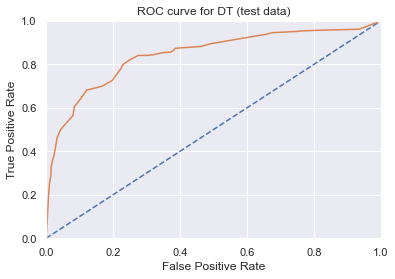

In [80]:
probabilities_test = best_model_tree.predict_proba(test_data_features)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(test_data_target, probabilities_one_test)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC curve for DT (test data)')
plt.show()

In [81]:
auc_roc = roc_auc_score(test_data_target, probabilities_one_test)
print(f'Decision Tree (test data) // AUC score: {auc_roc}')

Decision Tree (test data) // AUC score: 0.8432696339300113


### 4.1.2 AUC-ROC score for Random Forest model

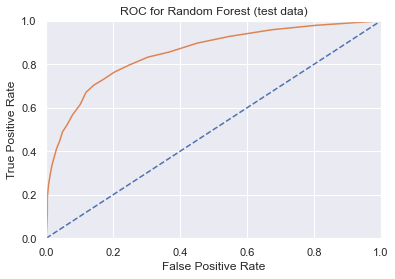

In [82]:
probabilities_test = best_model_random_forest.predict_proba(test_data_features)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(test_data_target, probabilities_one_test)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC for Random Forest (test data)')
plt.show()

In [83]:
auc_roc = roc_auc_score(test_data_target, probabilities_one_test)
print(f'Random Forest (test data) // AUC score: {auc_roc}')

Random Forest (test data) // AUC score: 0.8529269472665699


## 5 - General conclusions

### 5.1 The best model for forecasting target 'Exited' in the Bet Bank is Random Forest:

- **F1-мера: 0.60**
- **AUC-score: 0.85**

### 5.2 How different features in the dataset affect target value 'Exited'?

In [85]:
import seaborn as sp

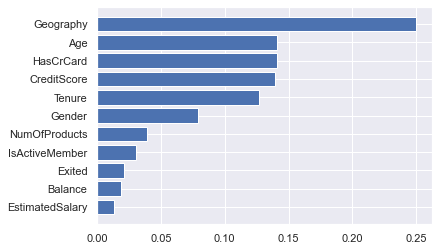

In [86]:
importance = best_model_random_forest.feature_importances_
indices = np.argsort(importance)

fig, ax = plt.subplots()
ax.barh(range(len(importance)), importance[indices])
ax.set_yticks(range(len(importance)))
_ = ax.set_yticklabels(np.array(data.columns)[indices])

**The strongest effect to the target value is made by *Geography* feature. *Age, CreditCard, Tenure, CreditScore* features influence the target equally (going after *Geography*). *Gender* also influences the target.** The rest of the features are small influencers.

Thank you for going through this projet. Your comments are more then welcome to ybezginova2021@gmail.com

Best wishes,

Yulia